# Chapter 7

In [313]:
import numpy as np
import random
import pandas as pd
import scipy.stats
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split
import itertools

import matplotlib as plt
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib as mpl
mpl.rc("figure", facecolor="white")
plt.rc('axes', axisbelow=True)

import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
import arviz as az

import altair as alt
from vega_datasets import data as data_alt

# data

In [2]:
data = pd.read_csv('tulips.txt', sep=';')
data.head(2)

,bed,water,shade,blooms
0,a,1,1,0.0
1,a,1,2,0.0


In [3]:
data['bed'].unique()

array(['a', 'b', 'c'], dtype=object)

In [4]:
data['water'].unique()

array([1, 2, 3])

In [5]:
x = 2
x

2

In [6]:
data['shade'].unique()

array([1, 2, 3])

In [7]:
data['blooms'].unique()

array([  0.  , 111.04, 183.47,  59.16,  76.75, 224.97,  83.77, 134.95,
        80.1 ,  85.95,  19.87, 213.13, 124.99,  65.48, 361.66, 197.13,
       134.93,  10.02,  47.69, 106.75, 246.  , 135.92,  90.66, 304.52,
       249.33, 134.59])

In [8]:
# scale the blooms feature
data['blooms_sc'] = data['blooms'] - data['blooms'].mean()
data['shade'] = data['shade'] - data['shade'].mean()
data['water'] = data['water'] - data['water'].mean()

In [9]:
# convert bed into a dummy variable
data['obs'] = data.index.to_list()
dumms = pd.get_dummies(data['bed'])
dumms['obs'] = dumms.index.to_list()
data = data.merge(dumms)

In [10]:
data.head(2)

,bed,water,shade,blooms,blooms_sc,obs,a,b,c
0,a,-1.0,-1.0,0.0,-128.993704,0,1,0,0
1,a,-1.0,0.0,0.0,-128.993704,1,1,0,0


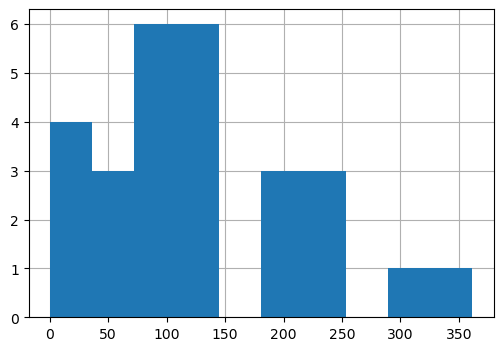

In [11]:
plt.figure(figsize=(6,4))
plt.grid()
plt.hist(data['blooms'])
plt.show()

# H1

In [13]:
# make two models, one including bed and one not including bed

# no bed
with pm.Model() as model_1:
    
    # priors
    alpha = pm.Normal('alpha', 0, 100)
    bS = pm.Normal('bS', 0, 100)
    bW = pm.Normal('bW', 0, 100)
    bSW = pm.Normal('bSW', 0, 100)
    sigma = pm.Uniform('sigma', 0, 100)
    
    # deterministic
    mu = alpha + bW*data['water'] + bS*data['shade'] + bSW*data['water']*data['shade']
    
    # likelihood
    blooms = pm.Normal('blooms', mu, sigma, observed=data['blooms'])
    
    trace_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bSW, bW, bS, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


In [14]:
# YES bed
with pm.Model() as model_2:
    
    # priors
    alpha = pm.Normal('alpha', 0, 100)
    bS = pm.Normal('bS', 0, 100)
    bW = pm.Normal('bW', 0, 100)
    bSW = pm.Normal('bSW', 0, 100)
    sigma = pm.Uniform('sigma', 0, 100)
    
    bA = pm.Normal('bA', 0, 100)
    bB = pm.Normal('bB', 0, 100)
    bC = pm.Normal('bC', 0, 100)
    
    
    # deterministic
    mu = alpha + bW*data['water'] + bS*data['shade'] + bSW*data['water']*data['shade'] \
        + bA*data['a'] + bB*data['b'] + bC*data['c']
    
    # likelihood
    blooms = pm.Normal('blooms', mu, sigma, observed=data['blooms'])
    
    trace_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bC, bB, bA, sigma, bSW, bW, bS, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


# H2

In [15]:
model_1.name = 'model_1'
model_2.name = 'model_2'

waic_df = pm.compare({model_1.name:trace_1,
            model_2.name:trace_2}, ic='WAIC')


waic_df['waic'] = waic_df['waic']*-2

waic_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,289.54,5.74764,0,0.73011,3.57246,0,True,log
model_1,1,293.188,4.33019,1.82398,0.26989,3.17362,2.67116,True,log


In [16]:
# about the same

In [17]:
# compare the models here


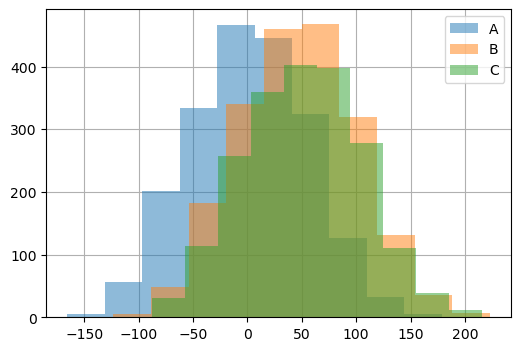

In [18]:
# posterior plots of the model coeffs for the bed variable
plt.figure(figsize=(6, 4))

for bed in data['bed'].unique():
    bed = bed.upper()
    plt.hist(trace_2[f'b{bed}'], label=bed, alpha=0.5)
    
plt.grid()
plt.legend()
plt.show()

# H3

In [108]:
rugged = pd.read_csv('rugged.txt', sep=';')
rugged.head(2)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0


In [109]:
rugged.shape

(234, 51)

In [110]:
# pick out the columns that we need
cols = ['country', 'rgdppc_2000', 'rugged', 'cont_africa']
data = rugged[cols]
data.head(2)

,country,rgdppc_2000,rugged,cont_africa
0,Aruba,NaN,0.462,0
1,Afghanistan,NaN,2.518,0


In [111]:
data[data['rgdppc_2000'].isna()].shape

(64, 4)

In [112]:
data[data['rgdppc_2000'].isna()].groupby('cont_africa').size()

cont_africa
0    56
1     8
dtype: int64

In [113]:
data.shape

(234, 4)

In [114]:
# drop the ones that we are missing
data = data[~data['rgdppc_2000'].isna()]
data.head(2)

,country,rgdppc_2000,rugged,cont_africa
2,Angola,1794.729,0.858,1
4,Albania,3703.113,3.427,0


In [115]:
data.shape

(170, 4)

In [25]:
data[data['rugged'].isna()]

,country,rgdppc_2000,rugged,cont_africa


In [26]:
data[data['cont_africa'].isna()]

,country,rgdppc_2000,rugged,cont_africa


In [27]:
# log transform, use natural log to follow what the text did
data['log_gdp'] = data['rgdppc_2000'].apply(lambda x: np.log(x))

In [28]:
data.head(2)

,country,rgdppc_2000,rugged,cont_africa,log_gdp
2,Angola,1794.729,0.858,1,7.492609
4,Albania,3703.113,3.427,0,8.216929


In [29]:
# this problem will be looking at Seychelles, make sure we have it
data[data['country'].str.contains('Seych')]

,country,rgdppc_2000,rugged,cont_africa,log_gdp
198,Seychelles,17957.47,4.885,1,9.795761


In [30]:
data['is_seych'] = data['country'].apply(lambda x: '1' if 'Seych' in x else '0')
data['is_africa'] = data['cont_africa'].apply(lambda x: '1' if x == 1 else '0')

In [31]:
data.head(2)

,country,rgdppc_2000,rugged,cont_africa,log_gdp,is_seych,is_africa
2,Angola,1794.729,0.858,1,7.492609,0,1
4,Albania,3703.113,3.427,0,8.216929,0,0


In [32]:
data[data['country'].str.contains('Seych')]

,country,rgdppc_2000,rugged,cont_africa,log_gdp,is_seych,is_africa
198,Seychelles,17957.47,4.885,1,9.795761,1,1


In [33]:
data['cont_africa'] = data['cont_africa']

In [34]:
# plot the data to see where this point is
alt.Chart(data).mark_point(size=200).encode(
    x='rugged',
    y=alt.X('log_gdp', scale=alt.Scale(domain=[5, 12])),
    fill='is_africa',
    shape='is_seych').properties(width=333, height=333).display()

alt.Chart(...)

In [35]:
# and there you have it, seychelles is a rich rugged country

In [50]:
# model WITH seych
with pm.Model() as model_seych:
    
    # priors
    alpha = pm.Normal('alpha', 8, 100)
    bA = pm.Normal('bA', 0, 1)
    bR = pm.Normal('bR', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data['log_gdp'])
    
    trace_yes = pm.sample(1000)
    
    preds_yes = pm.sample_posterior_predictive(trace_yes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8838407454376791, but should be close to 0.8. Try to increase the number of tuning steps.


In [51]:
# model NO seych
data_no = data[~data['country'].str.contains('Seych')]

with pm.Model() as model_no_seych:
    
    # priors
    alpha = pm.Normal('alpha', 8, 100)
    bA = pm.Normal('bA', 0, 1)
    bR = pm.Normal('bR', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data_no['cont_africa'] + bR*data_no['rugged'] + bAR*data_no['cont_africa']*data_no['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data_no['log_gdp'])
    
    trace_no = pm.sample(1000)
    preds_no = pm.sample_posterior_predictive(trace_no)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


In [40]:
# we will be plotting posterior predictions in the next question
# so here lets just look at the interaction coeff

In [41]:
# WITH seych
with_stats = az.summary(trace_yes, round_to=2).reset_index().rename(columns={'index':'parameter'})
with_stats

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,alpha,9.18,0.15,8.90,9.44,0.01,0.00,699.43,699.43,715.63,952.82,1.01
1,bA,-1.84,0.23,-2.32,-1.45,0.01,0.01,760.93,760.93,775.05,841.31,1.01
2,bR,-0.18,0.08,-0.33,-0.03,0.00,0.00,800.87,800.87,821.63,1027.49,1.01
3,bAR,0.35,0.14,0.08,0.59,0.00,0.00,881.59,881.59,891.41,972.62,1.01
4,sigma,0.95,0.05,0.86,1.06,0.00,0.00,1503.71,1503.71,1481.29,804.78,1.00


In [42]:
# calculate the interaction term
bR = with_stats[with_stats['parameter'] == 'bR']['mean'].values[0]
bAR = with_stats[with_stats['parameter'] == 'bAR']['mean'].values[0]

# in Africa
print(bR + bAR)

0.16999999999999998


In [43]:
# WITHOUT seych
without_stats = az.summary(trace_no, round_to=2).reset_index().rename(columns={'index':'parameter'})
without_stats

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,alpha,9.18,0.14,8.93,9.45,0.01,0.00,763.37,762.79,757.95,1004.01,1.0
1,bA,-1.78,0.23,-2.21,-1.36,0.01,0.01,883.59,883.59,884.92,993.45,1.0
2,bR,-0.18,0.08,-0.33,-0.04,0.00,0.00,752.12,752.12,745.59,1222.55,1.0
3,bAR,0.25,0.14,-0.02,0.52,0.00,0.00,1041.80,1001.77,1051.87,1120.72,1.0
4,sigma,0.94,0.05,0.85,1.05,0.00,0.00,1987.57,1973.66,2012.59,1463.28,1.0


In [44]:
# calculate the interaction term
bR = without_stats[without_stats['parameter'] == 'bR']['mean'].values[0]
bAR = without_stats[without_stats['parameter'] == 'bAR']['mean'].values[0]

# in Africa
print(bR + bAR)

0.07


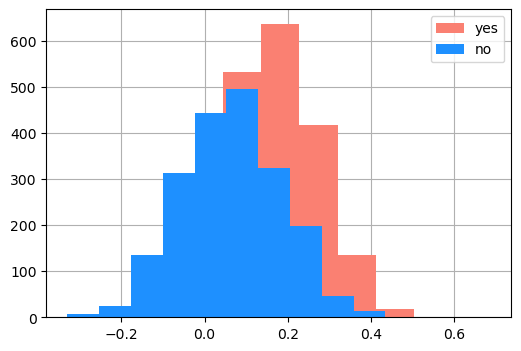

In [49]:
# interaction term, for in Africa, goes down quite a bit
# outside of Africa makes no difference
# plot the distribution of the interaction terms for in Africa here
yes_sech = trace_yes['bR'] + trace_yes['bAR']
no_sech = trace_no['bR'] + trace_no['bAR']

plt.figure(figsize=(6,4))
plt.hist(yes_sech, color='salmon', label='yes')
plt.hist(no_sech, color='dodgerblue', label='no')
plt.grid()
plt.legend()
plt.show()

## 3B

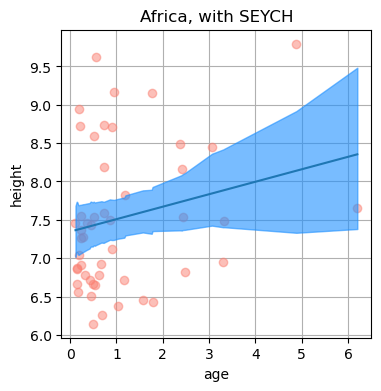

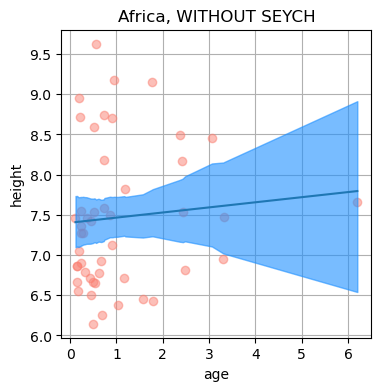

In [84]:
# will calculate the MAP mean and 97% interval
# with seych
#mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']
alpha_map = trace_yes['alpha'].mean()
bA_map = trace_yes['bA'].mean()
bR_map = trace_yes['bR'].mean()
bAR_map = trace_yes['bAR'].mean()

gdp_map = alpha_map + bA_map*data['cont_africa'] + bR_map*data['rugged'] + bAR_map*data['cont_africa']*data['rugged']

# get the 97% Ci
ci = 0.97
lower = []; upper = []
for cont, rug in zip(data['cont_africa'], data['rugged']):
    
    sample_ = np.array(trace_yes['alpha'] + trace_yes['bA']*cont + trace_yes['bR']*rug + trace_yes['bAR']*cont*rug)
    
    lower_, upper_ = pm.stats.hpd(sample_, alpha=ci)
    lower.append(lower_)
    upper.append(upper_)
    
data['gdp_map'] = gdp_map
data['lower'] = lower
data['upper'] = upper    


### for Africa
data_af = data[data['cont_africa'] == 1]

plt.figure(figsize=(4,4))

# raw data
plt.scatter(data_af['rugged'], data_af['log_gdp'], alpha=0.5, color='salmon')

# map regression line
map_pd = data_af.sort_values(by=['rugged'])
plt.plot(map_pd['rugged'], map_pd['gdp_map'])

# 95% interval of mean
int_pd = data_af.sort_values(by=['rugged'], ascending=True)
plt.fill_between(int_pd['rugged'], int_pd['lower'], int_pd['upper'], alpha=0.6, color='dodgerblue')

plt.title('Africa, with SEYCH')
plt.xlabel('age')
plt.ylabel('height')
plt.grid()




# WITHOUT SEYCH
alpha_map = trace_no['alpha'].mean()
bA_map = trace_no['bA'].mean()
bR_map = trace_no['bR'].mean()
bAR_map = trace_no['bAR'].mean()

gdp_map = alpha_map + bA_map*data_no['cont_africa'] + bR_map*data_no['rugged'] + bAR_map*data_no['cont_africa']*data_no['rugged']

# get the 97% Ci
ci = 0.97
lower = []; upper = []
for cont, rug in zip(data_no['cont_africa'], data_no['rugged']):
    
    sample_ = np.array(trace_no['alpha'] + trace_no['bA']*cont + trace_no['bR']*rug + trace_no['bAR']*cont*rug)
    
    lower_, upper_ = pm.stats.hpd(sample_, alpha=ci)
    lower.append(lower_)
    upper.append(upper_)
    
data_no['gdp_map'] = gdp_map
data_no['lower'] = lower
data_no['upper'] = upper    


### for Africa; witout SEYCH
data_af = data_no[data_no['cont_africa'] == 1]

plt.figure(figsize=(4,4))

# raw data
plt.scatter(data_af['rugged'], data_af['log_gdp'], alpha=0.5, color='salmon')

# map regression line
map_pd = data_af.sort_values(by=['rugged'])
plt.plot(map_pd['rugged'], map_pd['gdp_map'])

# 95% interval of mean
int_pd = data_af.sort_values(by=['rugged'], ascending=True)
plt.fill_between(int_pd['rugged'], int_pd['lower'], int_pd['upper'], alpha=0.6, color='dodgerblue')

plt.title('Africa, WITHOUT SEYCH')
plt.xlabel('age')
plt.ylabel('height')
plt.grid()




In [85]:
# less obvious trend now

## 3C

In [116]:
# build three different models
data_no.head()

,country,rgdppc_2000,rugged,cont_africa,log_gdp,is_seych,is_africa,gdp_map,lower,upper,mean
2,Angola,1794.729,0.858,1,7.492609,0,1,7.456540,6.239088,10.754212,8.291165
4,Albania,3703.113,3.427,0,8.216929,0,0,8.549894,6.512995,10.779456,8.536281
7,United Arab Emirates,20604.460,0.769,0,9.933263,0,0,9.041678,6.479146,10.783130,8.662075
8,Argentina,12173.680,0.775,0,9.407032,0,0,9.040568,6.454744,10.628659,8.635537
9,Armenia,2421.985,2.688,0,7.792343,0,0,8.686624,6.374565,10.591136,8.516678


In [118]:
data_no.shape

(169, 11)

In [119]:
rugged.shape

(234, 51)

In [120]:
with pm.Model() as model_1:
    # priors
    alpha = pm.Normal('alpha', 8, 100)
    bR = pm.Normal('bR', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bR*data_no['rugged'] 
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data_no['log_gdp'])
    trace_1 = pm.sample(1000)



with pm.Model() as model_2:
    # priors
    alpha = pm.Normal('alpha', 8, 100)
    bA = pm.Normal('bA', 0, 1)
    bR = pm.Normal('bR', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data_no['cont_africa'] + bR*data_no['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data_no['log_gdp'])
    trace_2 = pm.sample(1000)
    
    

with pm.Model() as model_3:
    # priors
    alpha = pm.Normal('alpha', 8, 100)
    bA = pm.Normal('bA', 0, 1)
    bR = pm.Normal('bR', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data_no['cont_africa'] + bR*data_no['rugged'] + bAR*data_no['cont_africa']*data_no['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data_no['log_gdp'])
    trace_3 = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


In [124]:
model_1.name = 'model_1'
model_2.name = 'model_2'
model_3.name = 'model_3'

waic_df = pm.compare({model_1.name:trace_1,
                      model_2.name:trace_2, 
                      model_3.name:trace_3}, ic='WAIC')


waic_df['waic'] = waic_df['waic']*-2
waic_df = waic_df.reset_index().rename(columns={'index':'model'}).sort_values(by=['model'], ascending=True)
waic_df

,model,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
2,model_1,2,536.241,2.64912,36.6596,2.65863e-08,7.20924,7.34542,False,log
1,model_2,1,465.974,3.78054,1.52585,0.262387,6.98361,1.60149,False,log
0,model_3,0,462.922,4.23608,0,0.737613,6.54284,0,True,log


In [125]:
# model 3 is the best, model 1 sucks
# predictions model averaged
traces = [trace_1, trace_2, trace_3]
models = [model_1, model_2, model_3]


ppc_w = pm.sample_posterior_predictive_w(traces, 2000, models,
                        weights=waic_df['weight'].values,
                        progressbar=True)

In [136]:
waic_df['weight'].values

array([2.658627887109357e-08, 0.26238678456576264, 0.7376131888479583],
      dtype=object)

(array([ 15.,  62., 185., 369., 515., 418., 265., 132.,  29.,  10.]),
 array([ 4.67445103,  5.26256166,  5.85067229,  6.43878292,  7.02689355,
         7.61500419,  8.20311482,  8.79122545,  9.37933608,  9.96744671,
        10.55555734]),
 <a list of 10 Patch objects>)

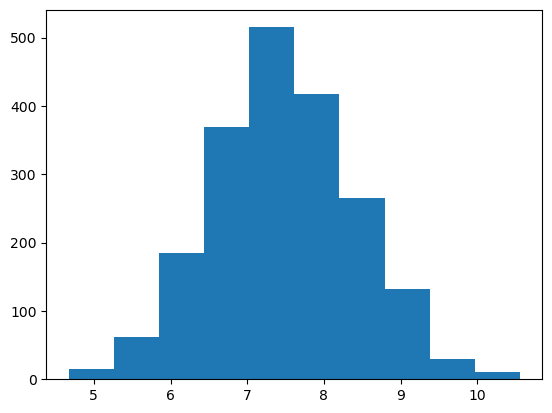

In [140]:
plt.hist(pred)

In [144]:
scipy.stats.describe(pred)

DescribeResult(nobs=2000, minmax=(4.674451028761299, 10.555557344043628), mean=7.472865034761952, variance=0.8611959601199373, skewness=0.06320548496494967, kurtosis=-0.05499145515133996)

In [145]:
pred.var()

0.8607653621398773

In [146]:
pred.std()

0.9277744133893094

In [148]:
0.86**0.5

0.9273618495495703

In [152]:
ppc_w['log_gdp']

array([[ 8.56069418,  9.40622892,  8.82273691, ...,  9.1015098 ,
         6.62113193,  7.4632121 ],
       [ 7.27958665,  7.84863116,  9.11427675, ...,  7.22112462,
         8.89022283,  7.14580221],
       [ 8.35331177,  8.88523724,  9.34001865, ...,  9.45999827,
         7.79219606,  7.06585627],
       ...,
       [ 6.50455303,  8.06017887, 10.12270414, ...,  6.2996454 ,
         7.75640636,  7.70965387],
       [ 8.28621647,  7.68829877,  8.75206064, ...,  9.37928109,
         6.00736354,  8.07520961],
       [ 7.56897224,  9.28935865,  9.55596173, ...,  7.8176052 ,
         7.76874219,  8.10415577]])

In [127]:
# we have 1000 samples for each train observation
# plot the mean and 97% interval for comparison

# matrix is pred x observation
means = []; lowers = []; uppers = [] 
for obs in range(ppc_w['log_gdp'].shape[1]):
    
    pred = ppc_w['log_gdp'][:, obs]
    mean = pred.mean()
    lower_, upper_ = pm.stats.hpd(pred, alpha=0.97)
    means.append(mean)
    lowers.append(lower_)
    uppers.append(upper_)
    
data_no['mean'] = means
data_no['lower'] = lowers
data_no['upper'] = uppers
data_no.head()

,country,rgdppc_2000,rugged,cont_africa,log_gdp,is_seych,is_africa,gdp_map,lower,upper,mean
2,Angola,1794.729,0.858,1,7.492609,0,1,7.456540,5.726399,9.385420,7.480649
4,Albania,3703.113,3.427,0,8.216929,0,0,8.549894,6.766692,10.349971,8.576690
7,United Arab Emirates,20604.460,0.769,0,9.933263,0,0,9.041678,7.219179,10.785075,9.037799
8,Argentina,12173.680,0.775,0,9.407032,0,0,9.040568,7.114463,10.711988,9.036414
9,Armenia,2421.985,2.688,0,7.792343,0,0,8.686624,7.112080,10.666588,8.715727


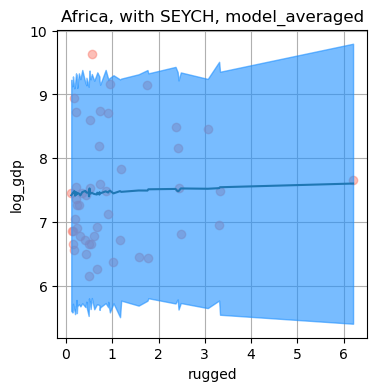

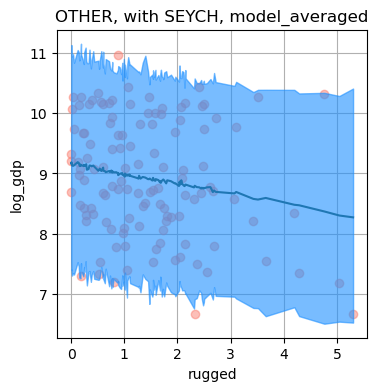

In [128]:
### for Africa
data_af = data_no[data_no['cont_africa'] == 1]

plt.figure(figsize=(4,4))

# raw data
plt.scatter(data_af['rugged'], data_af['log_gdp'], alpha=0.5, color='salmon')

# map regression line
map_pd = data_af.sort_values(by=['rugged'])
plt.plot(map_pd['rugged'], map_pd['mean'])

# 95% interval of mean
int_pd = data_af.sort_values(by=['rugged'], ascending=True)
plt.fill_between(int_pd['rugged'], int_pd['lower'], int_pd['upper'], alpha=0.6, color='dodgerblue')

plt.title('Africa, with SEYCH, model_averaged')
plt.xlabel('rugged')
plt.ylabel('log_gdp')
plt.grid()



### for Africa
data_af = data_no[data_no['cont_africa'] == 0]

plt.figure(figsize=(4,4))

# raw data
plt.scatter(data_af['rugged'], data_af['log_gdp'], alpha=0.5, color='salmon')

# map regression line
map_pd = data_af.sort_values(by=['rugged'])
plt.plot(map_pd['rugged'], map_pd['mean'])

# 95% interval of mean
int_pd = data_af.sort_values(by=['rugged'], ascending=True)
plt.fill_between(int_pd['rugged'], int_pd['lower'], int_pd['upper'], alpha=0.6, color='dodgerblue')

plt.title('OTHER, with SEYCH, model_averaged')
plt.xlabel('rugged')
plt.ylabel('log_gdp')
plt.grid()




# H4

In [256]:
data = pd.read_csv('nettle.txt', sep=';')
data.head(2)

,country,num.lang,area,k.pop,num.stations,mean.growing.season,sd.growing.season
0,Algeria,18,2381741,25660,102,6.60,2.29
1,Angola,42,1246700,10303,50,6.22,1.87


In [257]:
# use this data to evaluate hypothesis that language diversity is product of food security
# we will try to model the number of languages per capita
data['log_lang_cap'] = np.log(data['num.lang'] / data['k.pop'])
data['log_area'] = data['area'].apply(np.log)

In [258]:
data.shape

(74, 9)

In [259]:
data.head(2)

,country,num.lang,area,k.pop,num.stations,mean.growing.season,sd.growing.season,log_lang_cap,log_area
0,Algeria,18,2381741,25660,102,6.60,2.29,-7.262317,14.683342
1,Angola,42,1246700,10303,50,6.22,1.87,-5.502521,14.036011


In [260]:
scipy.stats.describe(data['log_lang_cap'])

DescribeResult(nobs=74, minmax=(-9.281357859211463, -0.38421999949442825), mean=-5.456606132615029, variance=2.3126681940454623, skewness=0.45548313923644085, kurtosis=1.3017181780114235)

In [261]:
# this is an open question; try to evaluate main effects of mean.growing.season and sd.growing.season
# as outlined in prob statements to come

# A

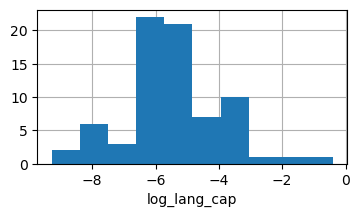

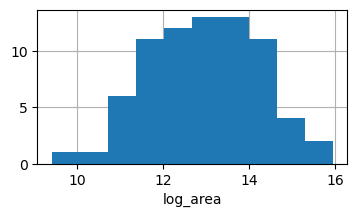

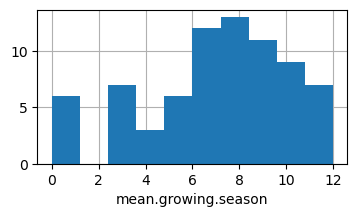

In [262]:
# evaluate lang diveristy / capita is positively associated with lenth of growing season
# include log(area) in regression as covariate
cols = ['log_lang_cap', 'log_area', 'mean.growing.season']
for col in cols:    
    plt.figure(figsize=(4,2))
    plt.hist(data[col])
    plt.xlabel(col)
    plt.grid()
    plt.show()
    

In [263]:
data['log_lang_cap'].mean()

-5.456606132615029

In [264]:
data['log_lang_cap'].std()

1.5207459334305198

In [265]:
# normalize the features
data['log_area_sc'] = data['log_area'] - data['log_area'].mean()
data['mean.growing.season_sc'] = data['mean.growing.season'] - data['mean.growing.season'].mean()

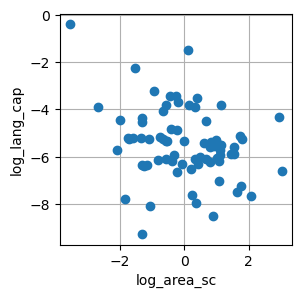

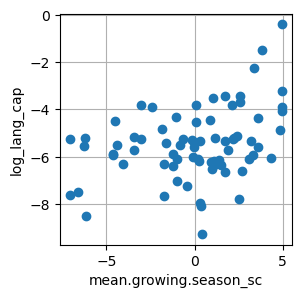

In [266]:
plt.figure(figsize=(3,3))
plt.scatter(data['log_area_sc'], data['log_lang_cap'])
plt.xlabel('log_area_sc')
plt.ylabel('log_lang_cap')
plt.grid()
plt.show()


plt.figure(figsize=(3,3))
plt.scatter(data['mean.growing.season_sc'], data['log_lang_cap'])
plt.xlabel('mean.growing.season_sc')
plt.ylabel('log_lang_cap')
plt.grid()
plt.show()


In [267]:
cols

['log_lang_cap', 'log_area', 'mean.growing.season']

In [268]:
with pm.Model() as model_a:
    # priors
    alpha = pm.Normal('alpha', -5, 1.5)
    bA = pm.Normal('bA', 0, 2)
    bB = pm.Normal('bB', 0, 2)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data['mean.growing.season_sc'] + bB*data['log_area_sc'] 
    
    # likelihood
    log_lang_cap = pm.Normal('log_lang_cap', mu, sigma, observed=data['log_lang_cap'])
    trace_a = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bB, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


In [269]:
az.summary(trace_a, round_to=2).reset_index()

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,alpha,-5.44,0.17,-5.77,-5.14,0.0,0.0,2044.34,2044.34,2066.33,1441.97,1.0
1,bA,0.14,0.06,0.04,0.26,0.0,0.0,2190.13,2063.05,2191.81,1566.37,1.0
2,bB,-0.20,0.14,-0.49,0.04,0.0,0.0,2025.18,1898.42,2023.76,1685.19,1.0
3,sigma,1.45,0.13,1.22,1.70,0.0,0.0,2388.92,2276.24,2531.47,1607.40,1.0


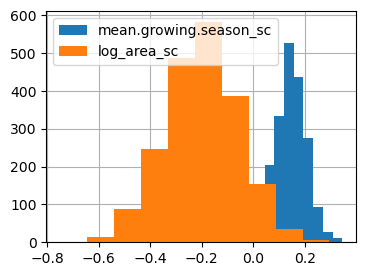

In [270]:
plt.figure(figsize=(4,3))
plt.hist(trace_a['bA'], label='mean.growing.season_sc')
plt.hist(trace_a['bB'], label='log_area_sc')
plt.legend()
plt.grid()
plt.show()


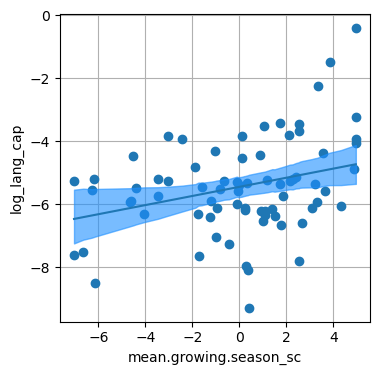

In [279]:
# seems to be positively associated, the posterior is solidly > 0
# show MAP mean and 96% CI for this parameter
# mu = alpha + bA*data['mean.growing.season_sc'] + bB*data['log_area_sc'] 

map_bA = trace_a['bA'].mean()
map_bB = trace_a['bB'].mean()
map_alpha = trace_a['alpha'].mean()
map_ = map_alpha + map_bA*data['mean.growing.season_sc'] + map_bB*data['log_area_sc'].mean()
map_pd = pd.DataFrame({'map':map_, 'mean.growing.season_sc':data['mean.growing.season_sc']})

plt.figure(figsize=(4,4))
plt.scatter(data['mean.growing.season_sc'], data['log_lang_cap'])

# map regression line
map_pd = map_pd.sort_values(by='mean.growing.season_sc')
plt.plot(map_pd['mean.growing.season_sc'], map_pd['map'])

# get the CI
ci = 0.96
lower = []; upper = []
for i, j in zip(data['mean.growing.season_sc'], data['log_area_sc']):
    sample_ = np.array(trace_a['alpha'] + i*trace_a['bA'] + data['log_area_sc'].mean()*trace_a['bB'])
    lower_, upper_ = pm.stats.hpd(sample_, alpha=ci)
    lower.append(lower_)
    upper.append(upper_)
    
# 95% interval of mean
int_pd = pd.DataFrame({'x':data['mean.growing.season_sc'], 'low':lower, 'high':upper})
int_pd = int_pd.sort_values(by=['x'], ascending=True)
plt.fill_between(int_pd['x'], int_pd['low'], int_pd['high'], alpha=0.6, color='dodgerblue')
    

plt.xlabel('mean.growing.season_sc')
plt.ylabel('log_lang_cap')
plt.grid()
plt.show()

## B

In [283]:
# evaluate hypothesis that language diversity is negatively associated w/ stdev of growing season
# also include area
data['sd.growing.season_sc'] = data['sd.growing.season'] - data['sd.growing.season'].mean()

In [284]:
with pm.Model() as model_b:
    # priors
    alpha = pm.Normal('alpha', -5, 1.5)
    bA = pm.Normal('bA', 0, 2)
    bB = pm.Normal('bB', 0, 2)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data['sd.growing.season_sc'] + bB*data['log_area_sc'] 
    
    # likelihood
    log_lang_cap = pm.Normal('log_lang_cap', mu, sigma, observed=data['log_lang_cap'])
    trace_b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bB, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


In [286]:
az.summary(trace_b, round_to=2).reset_index()

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,alpha,-5.45,0.18,-5.76,-5.10,0.00,0.0,1909.62,1909.62,1924.86,1225.55,1.0
1,bA,-0.21,0.19,-0.58,0.15,0.01,0.0,1286.26,1286.26,1285.23,1458.85,1.0
2,bB,-0.23,0.16,-0.55,0.06,0.00,0.0,1266.00,1208.46,1266.78,1389.83,1.0
3,sigma,1.50,0.13,1.26,1.75,0.00,0.0,1985.32,1951.34,2014.15,1237.42,1.0


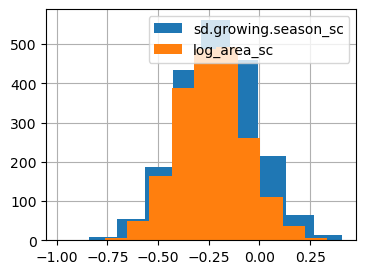

In [288]:
plt.figure(figsize=(4,3))
plt.hist(trace_b['bA'], label='sd.growing.season_sc')
plt.hist(trace_b['bB'], label='log_area_sc')
plt.legend()
plt.grid()
plt.show()

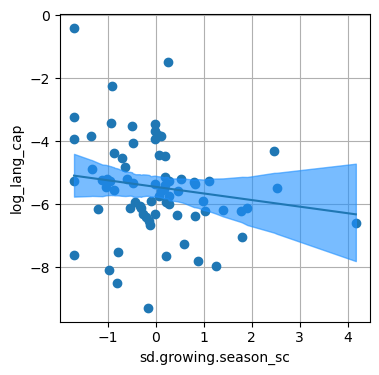

In [292]:
# hella negs
# seems to be positively associated, the posterior is solidly > 0
# show MAP mean and 96% CI for this parameter
# mu = alpha + bA*data['sd.growing.season_sc'] + bB*data['log_area_sc'] 


map_bA = trace_b['bA'].mean()
map_bB = trace_b['bB'].mean()
map_alpha = trace_a['alpha'].mean()
map_ = map_alpha + map_bA*data['sd.growing.season_sc'] + map_bB*data['log_area_sc'].mean()
map_pd = pd.DataFrame({'map':map_, 'sd.growing.season_sc':data['sd.growing.season_sc']})

plt.figure(figsize=(4,4))
plt.scatter(data['sd.growing.season_sc'], data['log_lang_cap'])

# map regression line
map_pd = map_pd.sort_values(by='sd.growing.season_sc')
plt.plot(map_pd['sd.growing.season_sc'], map_pd['map'])

# get the CI
ci = 0.96
lower = []; upper = []
for i, j in zip(data['sd.growing.season_sc'], data['log_area_sc']):
    sample_ = np.array(trace_b['alpha'] + i*trace_b['bA'] + data['log_area_sc'].mean()*trace_b['bB'])
    lower_, upper_ = pm.stats.hpd(sample_, alpha=ci)
    lower.append(lower_)
    upper.append(upper_)
    
# 95% interval of mean
int_pd = pd.DataFrame({'x':data['sd.growing.season_sc'], 'low':lower, 'high':upper})
int_pd = int_pd.sort_values(by=['x'], ascending=True)
plt.fill_between(int_pd['x'], int_pd['low'], int_pd['high'], alpha=0.6, color='dodgerblue')
    

plt.xlabel('sd.growing.season_sc')
plt.ylabel('log_lang_cap')
plt.grid()
plt.show()

In [293]:
# yes, seems to be a negative correlation


# C

In [ ]:
# evaluate the hypothesis that mean growing and sd growing season interact

In [298]:
with pm.Model() as model_c:
    # priors
    alpha = pm.Normal('alpha', -5, 1.5)
    bA = pm.Normal('bA', 0, 2)
    bB = pm.Normal('bB', 0, 2)
    bAB = pm.Normal('bAB', 0, 2) 
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data['sd.growing.season_sc'] + bB*data['mean.growing.season_sc'] + bAB*data['sd.growing.season_sc']*data['mean.growing.season_sc']
    
    # likelihood
    log_lang_cap = pm.Normal('log_lang_cap', mu, sigma, observed=data['log_lang_cap'])
    trace_c = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAB, bB, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [299]:
az.summary(trace_c)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-5.446,0.158,-5.734,-5.149,0.003,0.002,2378.0,2369.0,2388.0,1428.0,1.0
bA,-0.344,0.151,-0.613,-0.059,0.003,0.003,1924.0,1810.0,1889.0,1561.0,1.0
bB,0.114,0.058,-0.000,0.220,0.001,0.001,2007.0,1958.0,1963.0,1348.0,1.0
bAB,-0.108,0.049,-0.199,-0.017,0.001,0.001,1904.0,1759.0,1917.0,1477.0,1.0
sigma,1.368,0.116,1.157,1.592,0.003,0.002,1981.0,1945.0,2020.0,1531.0,1.0


In [306]:
# calculate the interaction term, gamma
sample_pd = pd.DataFrame({'bA':trace_c['bA'], 
                          'bB':trace_c['bB'], 
                          'bAB':trace_c['bAB']})

sample_pd['gamma']

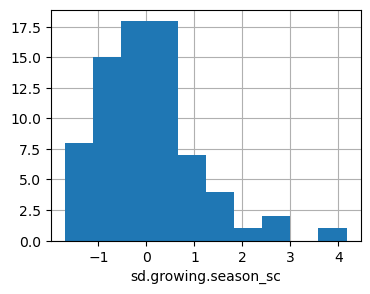

In [311]:
# ideally we make three different plots.  okay, i guess we will do that
# each column will be a different value of 'sd.growing.season_sc'
plt.figure(figsize=(4,3))
plt.hist(data['sd.growing.season_sc'])
plt.xlabel('sd.growing.season_sc')
plt.grid()
plt.show()

In [ ]:
# we will make plots for MAP predictions will using -1, 0, and +1 for sd.growing.season_sc


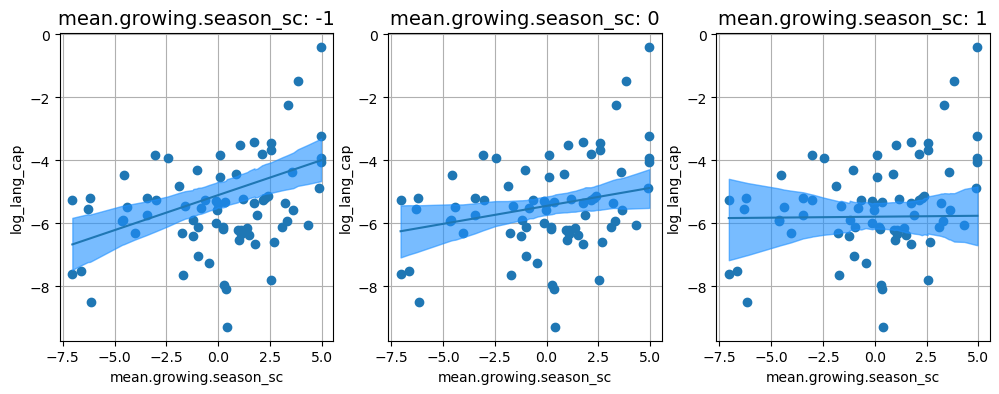

In [332]:
# mu = alpha + bA*data['sd.growing.season_sc'] + bB*data['mean.growing.season_sc'] 
# + bAB*data['sd.growing.season_sc']*data['mean.growing.season_sc']

map_bA = trace_c['bA'].mean()
map_bB = trace_c['bB'].mean()
map_bAB = trace_c['bAB'].mean()
map_alpha = trace_c['alpha'].mean()


# plot o'clock
plt.figure(figsize=(12,4))
    

for index, const in enumerate([-1, 0, 1]):
    map_ = map_alpha + map_bA*const + map_bB*data['mean.growing.season_sc']  + map_bAB*data['mean.growing.season_sc'] *const
    map_pd = pd.DataFrame({'map':map_, 'mean.growing.season_sc':data['mean.growing.season_sc']})
    
    # get the CI
    ci = 0.96
    lower = []; upper = []
    for i, j in zip(data['mean.growing.season_sc'], itertools.repeat(const)):
        sample_ = np.array(trace_c['alpha'] + const*trace_c['bA'] + i*trace_c['bB'] + const*i*trace_c['bAB'])
        lower_, upper_ = pm.stats.hpd(sample_, alpha=ci)
        lower.append(lower_)
        upper.append(upper_)
    
    
    int_pd = pd.DataFrame({'x':data['mean.growing.season_sc'], 'low':lower, 'high':upper})
    int_pd = int_pd.sort_values(by=['x'], ascending=True)

    # PLOT IT UP
    plt.subplot(1,3, index+1) 
    
    # raw data
    plt.scatter(data['mean.growing.season_sc'], data['log_lang_cap'])
    
    # map regression line
    map_pd = map_pd.sort_values(by='mean.growing.season_sc')
    plt.plot(map_pd['mean.growing.season_sc'], map_pd['map'])
    
    # ci
    plt.fill_between(int_pd['x'], int_pd['low'], int_pd['high'], alpha=0.6, color='dodgerblue')
    
    plt.title(f'mean.growing.season_sc: {const}', fontsize=14)
    plt.xlabel('mean.growing.season_sc')
    plt.ylabel('log_lang_cap')
    plt.grid()
    
plt.show()

In [307]:
plt.figure(figsize=(4,4))
plt.scatter(data['sd.growing.season_sc'], data['log_lang_cap'])

# map regression line
map_pd = map_pd.sort_values(by='sd.growing.season_sc')
plt.plot(map_pd['sd.growing.season_sc'], map_pd['map'])

# get the CI
ci = 0.96
lower = []; upper = []
for i, j in zip(data['sd.growing.season_sc'], data['log_area_sc']):
    sample_ = np.array(trace_b['alpha'] + i*trace_b['bA'] + data['log_area_sc'].mean()*trace_b['bB'])
    lower_, upper_ = pm.stats.hpd(sample_, alpha=ci)
    lower.append(lower_)
    upper.append(upper_)
    
# 95% interval of mean
int_pd = pd.DataFrame({'x':data['sd.growing.season_sc'], 'low':lower, 'high':upper})
int_pd = int_pd.sort_values(by=['x'], ascending=True)
plt.fill_between(int_pd['x'], int_pd['low'], int_pd['high'], alpha=0.6, color='dodgerblue')
    

plt.xlabel('sd.growing.season_sc')
plt.ylabel('log_lang_cap')
plt.grid()
plt.show()

,bA,bB,bAB
0,-0.320250,0.149648,-0.157676
1,-0.395061,0.113241,-0.030749
2,-0.344234,0.110670,-0.163890
3,-0.131657,0.031242,-0.103268
4,-0.187680,0.067495,-0.196132
...,...,...,...
1995,-0.482601,0.129809,-0.069050
1996,-0.341824,0.191125,-0.105792
1997,-0.117941,0.085368,-0.128187
1998,-0.223569,0.113142,-0.123332
